# Code used to create tables in the MIMIC-III paper

## Table 2: MIMIC-II patient population by critical care unit

In [263]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
%matplotlib inline

In [264]:
# Config
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

In [265]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
# cur.close()
# con.close()

These are the details that we would like to include in Table 2, grouped by first careunit:

- Hospital admissions, no. (% of total admissions)
- Distinct ICU stays, no. (% of total unit stays)
- Age, yrs, mean ± SD
- Gender, male, percent of unit stays
- ICU length of stay, median days (IQR)
- Hospital length of stay, median days (IQR)
- ICU mortality, percent of unit stays
- Hospital mortality, percent of unit stays

### Extract and review the data

In [266]:
# Join admissions, icustays, and patients tables

query = \
"""
SELECT a.subject_id, a.hadm_id, i.icustay_id, 
    a.admittime as hosp_admittime, a.dischtime as hosp_dischtime, 
    i.first_careunit, 
    DENSE_RANK() over(PARTITION BY a.hadm_id ORDER BY i.intime ASC) as icu_seq,
    p.dob, p.dod, i.intime as icu_intime, i.outtime as icu_outtime, 
    i.los as icu_los,
    round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los, 
    p.gender, 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_hosp_in,
    round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_icu_in,
    hospital_expire_flag,
    CASE WHEN p.dod IS NOT NULL 
        AND p.dod >= i.intime - interval '6 hour'
        AND p.dod <= i.outtime + interval '6 hour' THEN 1 
        ELSE 0 END AS icu_expire_flag
FROM admissions a
INNER JOIN icustays i
ON a.hadm_id = i.hadm_id
INNER JOIN patients p
ON a.subject_id = p.subject_id
ORDER BY a.subject_id, i.intime;
"""

query_output = pd.read_sql_query(query,con)
print(query_output.head())

   subject_id  hadm_id  icustay_id      hosp_admittime      hosp_dischtime  \
0           2   163353      243653 2138-07-17 19:04:00 2138-07-21 15:48:00   
1           3   145834      211552 2101-10-20 19:08:00 2101-10-31 13:58:00   
2           4   185777      294638 2191-03-16 00:28:00 2191-03-23 18:41:00   
3           5   178980      214757 2103-02-02 04:31:00 2103-02-04 12:15:00   
4           6   107064      228232 2175-05-30 07:15:00 2175-06-15 16:00:00   

  first_careunit  icu_seq        dob        dod          icu_intime  \
0           NICU        1 2138-07-17        NaT 2138-07-17 21:20:07   
1           MICU        1 2025-04-11 2102-06-14 2101-10-20 19:10:11   
2           MICU        1 2143-05-12        NaT 2191-03-16 00:29:31   
3           NICU        1 2103-02-02        NaT 2103-02-02 06:04:24   
4           SICU        1 2109-06-21        NaT 2175-05-30 21:30:54   

          icu_outtime  icu_los  hosp_los gender  age_hosp_in  age_icu_in  \
0 2138-07-17 23:32:21   0.09

### Hospital admissions, no. (% of total admissions)

In [267]:
print('\nTotal hospital admissions: {}')\
    .format(len(query_output.hadm_id.unique()))

print('\nNumber of hospital admissions by first careunit:\n')
print(query_output[['first_careunit','hadm_id']] \
                    .drop_duplicates(['hadm_id']) \
                    .groupby('first_careunit').count()).T
    
print('\nProportion of total hospital admissions:\n')
print(query_output[['first_careunit','hadm_id']] \
                    .drop_duplicates(['hadm_id']) \
                    .groupby('first_careunit') \
                    .count()/len(query_output.hadm_id.unique())*100).T


Total hospital admissions: 57786

Number of hospital admissions by first careunit:

first_careunit   CCU  CSRU   MICU  NICU  SICU  TSICU
hadm_id         7258  9157  19771  7992  8110   5498

Proportion of total hospital admissions:

first_careunit        CCU       CSRU      MICU      NICU       SICU     TSICU
hadm_id         12.560136  15.846399  34.21417  13.83034  14.034541  9.514415


### Distinct ICU stays, no. (% of total unit stays)

In [268]:
print('\nTotal ICU stays: {}')\
    .format(len(query_output.icustay_id.unique()))

print('\nNumber of ICU stays by careunit:\n')
print(query_output[['first_careunit','icustay_id']] \
          .groupby('first_careunit').count()).T

print('\nProportion of total ICU stays:\n')
print(query_output[['first_careunit','icustay_id']] \
          .groupby('first_careunit') \
          .count()/len(query_output.icustay_id.unique())*100).T


Total ICU stays: 61532

Number of ICU stays by careunit:

first_careunit   CCU  CSRU   MICU  NICU  SICU  TSICU
icustay_id      7726  9855  21088  8100  8891   5872

Proportion of total ICU stays:

first_careunit        CCU       CSRU       MICU       NICU       SICU  \
icustay_id      12.556068  16.016057  34.271599  13.163882  14.449392   

first_careunit     TSICU  
icustay_id      9.543002  


### Age, yrs, median ± IQR

In [269]:
# Better to report median IQR because >89 appear as 300
print('Median age, years: {} ').format(query_output.age_icu_in.median())
print('Lower quartile age, years: {} ').format(query_output.age_icu_in.quantile(0.25))
print('Upper quartile age, years: {} \n ').format(query_output.age_icu_in.quantile(0.75))

print('Median age by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').median()).T

print('\nLower quartile by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').quantile(0.25)).T

print('\nUpper quartile by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').quantile(0.75)).T


Median age, years: 62.07505 
Lower quartile age, years: 44.350675 
Upper quartile age, years: 76.0588 
 
Median age by careunit, years:
 
first_careunit      CCU     CSRU     MICU    NICU     SICU     TSICU
age_icu_in      70.5697  67.5974  64.9123  0.0018  63.5819  59.84315

Lower quartile by careunit, years:
 
first_careunit       CCU     CSRU      MICU   NICU      SICU      TSICU
age_icu_in      58.44555  57.6042  51.65295  0.001  51.44315  42.825125

Upper quartile by careunit, years:
 
first_careunit        CCU      CSRU       MICU    NICU     SICU     TSICU
age_icu_in      80.541375  76.68095  78.168925  0.0025  76.4575  75.63555


### Gender, male, percent of unit stays

In [270]:
print('Gender:\n')
print(query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count())
print(query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count() \
     /query_output.loc[query_output.icu_seq==1].gender.count()*100)

print('Gender by careunit:\n')
print(query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit','gender']).gender.count())

print('\nProportion by unit:\n')
print(query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit','gender']) \
    .gender.count()/query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit']).gender.count())*100

Gender:

gender
F    25488
M    32298
Name: gender, dtype: int64
gender
F    44.107569
M    55.892431
Name: gender, dtype: float64
Gender by careunit:

first_careunit  gender
CCU             F          3055
                M          4203
CSRU            F          3156
                M          6001
MICU            F          9578
                M         10193
NICU            F          3682
                M          4310
SICU            F          3859
                M          4251
TSICU           F          2158
                M          3340
Name: gender, dtype: int64

Proportion by unit:

first_careunit  gender
CCU             F         42.091485
                M         57.908515
CSRU            F         34.465436
                M         65.534564
MICU            F         48.444692
                M         51.555308
NICU            F         46.071071
                M         53.928929
SICU            F         47.583231
                M         52.416769
TSICU    

### ICU length of stay, median days (IQR)

In [271]:
print('Median ICU length of stay, days: {}').format(query_output.icu_los.median())
print('Lower quartile ICU length of stay, days: {}') \
    .format(query_output.icu_los.quantile(0.25))
print('Upper quartile ICU length of stay, days: {}\n') \
    .format(query_output.icu_los.quantile(0.75))

print('Median length of ICU stay by careunit, days:\n ')
print(query_output[['first_careunit','icu_los']] \
      .groupby('first_careunit').median()).T

print('\nLower quartile length of ICU stay, days:\n ')
print(query_output[['first_careunit','icu_los']] \
      .groupby('first_careunit').quantile(0.25)).T

print('\nUpper quartile length of ICU stay, days:\n ')
print(query_output[['first_careunit','icu_los']] \
      .groupby('first_careunit').quantile(0.75)).T


Median ICU length of stay, days: 2.09225
Lower quartile ICU length of stay, days: 1.108025
Upper quartile ICU length of stay, days: 4.483175

Median length of ICU stay by careunit, days:
 
first_careunit      CCU    CSRU    MICU    NICU    SICU    TSICU
icu_los         2.19775  2.1549  2.0955  0.8025  2.2522  2.10045

Lower quartile length of ICU stay, days:
 
first_careunit       CCU      CSRU      MICU   NICU     SICU     TSICU
icu_los         1.213225  1.216225  1.189125  0.141  1.25155  1.163275

Upper quartile length of ICU stay, days:
 
first_careunit      CCU      CSRU      MICU    NICU    SICU     TSICU
icu_los         4.14855  4.001575  4.095575  9.7436  4.9327  4.579425


### Hospital length of stay, median days (IQR)

In [272]:
# NB: hadm_id is repeated in data due to multiple ICU stays
# ...so need to drop duplicates
print('Median length of hospital stay, days: {}') \
    .format(query_output.drop_duplicates(['hadm_id']).hosp_los.median())
print('Lower quartile length of hospital stay, days: {}') \
    .format(query_output.drop_duplicates(['hadm_id']).hosp_los.quantile(0.25))
print('Upper quartile length of hospital stay, days: {}\n') \
    .format(query_output.drop_duplicates(['hadm_id']).hosp_los.quantile(0.75))

print('Median length of hospital stay, days:\n ')
print(query_output.drop_duplicates(['hadm_id']) \
      [['first_careunit','hosp_los']] \
      .groupby('first_careunit').median()).T

print('\nLower quartile length of hospital stay, days:\n ')
print(query_output.drop_duplicates(['hadm_id']) \
      [['first_careunit','hosp_los']] \
      .groupby('first_careunit').quantile(0.25)).T

print('\nUpper quartile length of hospital stay, days:\n ')
print(query_output.drop_duplicates(['hadm_id']) \
      [['first_careunit','hosp_los']] \
      .groupby('first_careunit').quantile(0.75)).T

Median length of hospital stay, days: 6.5549
Lower quartile length of hospital stay, days: 3.7889
Upper quartile length of hospital stay, days: 11.8549

Median length of hospital stay, days:
 
first_careunit     CCU    CSRU    MICU    NICU    SICU    TSICU
hosp_los        5.7576  7.3743  6.4222  4.1132  7.9313  7.43125

Lower quartile length of hospital stay, days:
 
first_careunit       CCU    CSRU     MICU      NICU    SICU     TSICU
hosp_los        3.105075  5.2396  3.67395  2.344925  4.4146  4.068425

Upper quartile length of hospital stay, days:
 
first_careunit        CCU     CSRU     MICU       NICU       SICU    TSICU
hosp_los        10.026225  11.3507  11.7299  10.262325  14.240125  13.5807


### ICU mortality, percent of unit stays

In [273]:
print('ICU mortality, number:\n')
print(query_output \
    .groupby(['icu_expire_flag']) \
    .icu_expire_flag.count())

print('\nICU mortality, %:\n')
print(query_output.groupby(['icu_expire_flag']) \
    .icu_expire_flag.count() / query_output.icu_expire_flag.count()*100)

print('\nICU mortality by careunit:\n')
print(query_output \
    .groupby(['first_careunit','icu_expire_flag']) \
    .icu_expire_flag.count())

print('\nProportion by unit:\n')
print(query_output \
    .groupby(['first_careunit','icu_expire_flag']) \
    .icu_expire_flag.count()/query_output \
    .groupby(['first_careunit']).icu_expire_flag.count())*100

ICU mortality, number:

icu_expire_flag
0    56913
1     4619
Name: icu_expire_flag, dtype: int64

ICU mortality, %:

icu_expire_flag
0    92.493337
1     7.506663
Name: icu_expire_flag, dtype: float64

ICU mortality by careunit:

first_careunit  icu_expire_flag
CCU             0                   7041
                1                    685
CSRU            0                   9502
                1                    353
MICU            0                  18866
                1                   2222
NICU            0                   8047
                1                     53
SICU            0                   8078
                1                    813
TSICU           0                   5379
                1                    493
Name: icu_expire_flag, dtype: int64

Proportion by unit:

first_careunit  icu_expire_flag
CCU             0                  91.133834
                1                   8.866166
CSRU            0                  96.418062
                1   

### Hospital mortality, percent of unit stays

In [274]:
# NB: hadm_id is repeated in data due to multiple ICU stays
# ...so need to drop duplicates
print('Hospital mortality, number:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['hospital_expire_flag']) \
    .hospital_expire_flag.count())

print('\nHospital mortality, %:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['hospital_expire_flag']) \
    .hospital_expire_flag.count() \
    / query_output.drop_duplicates(['hadm_id']).hospital_expire_flag.count()*100)

print('\nHospital mortality:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit','hospital_expire_flag']) \
    .hospital_expire_flag.count())

print('\nProportion by unit:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit','hospital_expire_flag']) \
    .hospital_expire_flag.count()/query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit']).hospital_expire_flag.count())*100

Hospital mortality, number:

hospital_expire_flag
0    51973
1     5813
Name: hospital_expire_flag, dtype: int64

Hospital mortality, %:

hospital_expire_flag
0    89.94047
1    10.05953
Name: hospital_expire_flag, dtype: float64

Hospital mortality:

first_careunit  hospital_expire_flag
CCU             0                        6441
                1                         817
CSRU            0                        8733
                1                         424
MICU            0                       16912
                1                        2859
NICU            0                        7928
                1                          64
SICU            0                        7090
                1                        1020
TSICU           0                        4869
                1                         629
Name: hospital_expire_flag, dtype: int64

Proportion by unit:

first_careunit  hospital_expire_flag
CCU             0                       88.743455
         

## Table 3: Distribution of primary ICD-9 codes in MIMIC-II

In [275]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
# cur.close()
# con.close()

In [276]:
# ICD Diagnoses are associated with hospital admissions, not ICU stay
# ...so select first ICU stay for breakdown.
# Select patients >= 16 on first admission

query = \
"""
WITH diagnoses_icu AS (
SELECT a.subject_id, a.hadm_id, i.icustay_id, 
    a.admittime as hosp_admittime, a.dischtime as hosp_dischtime, 
    i.first_careunit, 
    DENSE_RANK() over(PARTITION BY a.hadm_id ORDER BY i.intime ASC) as icu_seq,
    p.dob, p.dod, i.intime as icu_intime, i.outtime as icu_outtime, 
    i.los as icu_los,
    round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los, 
    p.gender, 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_hosp_in,
    round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_icu_in,
    hospital_expire_flag,
    CASE WHEN p.dod IS NOT NULL 
        AND p.dod >= i.intime - interval '6 hour'
        AND p.dod <= i.outtime + interval '6 hour' THEN 1 
        ELSE 0 END AS icu_expire_flag
    FROM admissions a
    INNER JOIN icustays i
    ON a.hadm_id = i.hadm_id
    INNER JOIN patients p
    ON a.subject_id = p.subject_id
    ORDER BY a.subject_id, i.intime)
SELECT d.subject_id, d.hadm_id, d.icustay_id, d.first_careunit,
    icd.seq_num, icd.icd9_code, left(icd.icd9_code,3) AS icd_first3, 
    CASE
        WHEN lower(LEFT(icd.icd9_code,1)) = 'e' THEN NULL
        WHEN lower(LEFT(icd.icd9_code,1)) = 'v' THEN NULL
        ELSE CAST( LEFT(icd.icd9_code,3) AS INT) END AS icd_first3_num,
    CASE 
        WHEN lower(LEFT(icd.icd9_code,1)) = 'e' THEN 9
        WHEN lower(LEFT(icd.icd9_code,1)) = 'v' THEN 9
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=0 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 139 THEN 0
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=140 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 239 THEN 1
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=240 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 279 THEN 2
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=390 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 459 THEN 3
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=460 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 519 THEN 4
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=520 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 579 THEN 5
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=580 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 629 THEN 6
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=800 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 959 THEN 7
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=960 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 989 THEN 8
        ELSE 9 END AS icd_first3_grp, 
    d_icd.short_title
FROM diagnoses_icu d
INNER JOIN diagnoses_icd icd
    ON d.hadm_id = icd.hadm_id
INNER JOIN d_icd_diagnoses d_icd
    ON icd.icd9_code = d_icd.icd9_code
WHERE seq_num =1
    AND age_hosp_in >=16;
"""

query_output = pd.read_sql_query(query,con)
print(query_output.head())

   subject_id  hadm_id  icustay_id first_careunit  seq_num icd9_code  \
0           3   145834      211552           MICU        1      0389   
1           4   185777      294638           MICU        1       042   
2           6   107064      228232           SICU        1     40391   
3           9   150750      220597           MICU        1       431   
4          11   194540      229441           SICU        1      1913   

  icd_first3  icd_first3_num  icd_first3_grp               short_title  
0        038              38               0            Septicemia NOS  
1        042              42               0    Human immuno virus dis  
2        403             403               3    Hyp kid NOS w cr kid V  
3        431             431               3  Intracerebral hemorrhage  
4        191             191               1     Mal neo parietal lobe  


### Most common ICD-9 codes

In [277]:
print('Primary ICD diagnoses by frequency:\n')
print(query_output['icd9_code'].value_counts().head())

print('\nPrimary ICD diagnoses, %:\n')
print(query_output['icd9_code'].value_counts().head() \
     /len(query_output['icd9_code'])*100)

Primary ICD diagnoses by frequency:

41401    3647
0389     2231
41071    1905
4241     1221
51881    1200
dtype: int64

Primary ICD diagnoses, %:

41401    6.924508
0389     4.235969
41071    3.616997
4241     2.318296
51881    2.278423
dtype: float64


### ICD-9 codes by careunit

In [278]:
print('Primary ICD diagnoses by ICU stay:\n')
a=query_output.loc[query_output.first_careunit=='CCU']['icd_first3_grp'].value_counts()
b=query_output.loc[query_output.first_careunit=='CSRU']['icd_first3_grp'].value_counts()
c=query_output.loc[query_output.first_careunit=='MICU']['icd_first3_grp'].value_counts()
d=query_output.loc[query_output.first_careunit=='SICU']['icd_first3_grp'].value_counts()
e=query_output.loc[query_output.first_careunit=='TSICU']['icd_first3_grp'].value_counts()
f=query_output['icd_first3_grp'].value_counts()
df_num=pd.concat([a,b,c,d,e,f],axis=1)
df_num.fillna(value=0, inplace=True)
df_num.columns = ['CCU', 'CSRU','MICU','SICU','TSICU','Total']
# Append a totals row
print(df_num.append(df_num.sum(), ignore_index=True))

print('\nProportion by careunit:\n')
a=(a/query_output.loc[query_output.first_careunit=='CCU']['icd_first3_grp'].count())*100
b=(b/query_output.loc[query_output.first_careunit=='CSRU']['icd_first3_grp'].count())*100
c=(c/query_output.loc[query_output.first_careunit=='MICU']['icd_first3_grp'].count())*100
d=(d/query_output.loc[query_output.first_careunit=='SICU']['icd_first3_grp'].count())*100
e=(e/query_output.loc[query_output.first_careunit=='TSICU']['icd_first3_grp'].count())*100
f=(f/query_output['icd_first3_grp'].count())*100
df_percent=pd.concat([a,b,c,d,e,f],axis=1)
df_percent.fillna(value=0, inplace=True)
df_percent.columns = ['CCU', 'CSRU','MICU','SICU','TSICU','Total']
# Append a totals row
print(df_percent.append( df_num.sum() * 100 / df_num.Total.sum(), ignore_index=True))

Primary ICD diagnoses by ICU stay:

     CCU  CSRU   MICU  SICU  TSICU  Total
0    350    99   3455   519    190   4613
1    148   312   1602  1360    503   3925
2    111    38   1014   196     54   1413
3   5366  7662   2791  2491    723  19033
4    452   155   3585   428    245   4865
5    292   171   3261  1385    512   5621
6    143    17    782   112     34   1088
7    115   512    551   897   2924   4999
8     50     2    591    60     11    714
9    625   799   3058  1309    606   6397
10  7652  9767  20690  8757   5802  52668

Proportion by careunit:

          CCU       CSRU       MICU       SICU      TSICU       Total
0    4.573968   1.013617  16.698888   5.926687   3.274733    8.758639
1    1.934135   3.194430   7.742871  15.530433   8.669424    7.452343
2    1.450601   0.389065   4.900918   2.238209   0.930714    2.682843
3   70.125457  78.447835  13.489609  28.445815  12.461220   36.137693
4    5.906952   1.586977  17.327211   4.887519   4.222682    9.237108
5    3.815996 

### Distribution of ICD codes, normalised by careunit

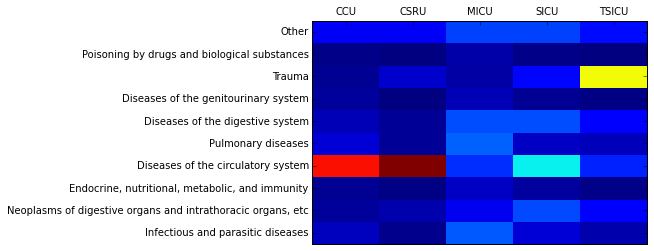

In [279]:
data = df_percent[['CCU', 'CSRU','MICU','SICU','TSICU']].values
row_labels = list(['CCU', 'CSRU','MICU','SICU','TSICU'])
column_labels = list(
    ['Infectious and parasitic diseases',
     'Neoplasms of digestive organs and intrathoracic organs, etc',
     'Endocrine, nutritional, metabolic, and immunity',
     'Diseases of the circulatory system',
     'Pulmonary diseases',
     'Diseases of the digestive system',
     'Diseases of the genitourinary system',
     'Trauma',
     'Poisoning by drugs and biological substances',
     'Other'])
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.jet)

# move labels to top
ax.xaxis.tick_top()

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
plt.show()